In [6]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
twopi= 2*np.pi

In [8]:
#from numpy.fft import rfft2
#from numpy.fft import irfft2
from numpy.fft import fft2
from numpy.fft import ifft2
from numpy.fft import fftfreq

Let's try a spectral method for Swift-Hohenburg eqn

$u_t = Lu + F(u) $ 

where the linear operator 

$L =  r - (\partial_{xx} + 1)^2 $

and the nonlinear part is

$F(u) = \gamma_u u^2 - u^3 $

In Fourier space $L_k = r - (k^2 -1)^2  = (r-1) -k^4  + 2k^2$


Let's look at the FT of $u_t = L u$ and do a Crank-Nicholson step

$u^{n+1}_k - u_k^n = \frac{\Delta t}{2} (  (L u)_k^{n+1}  +  (L u)_k^{n})$ 

$ (L u)_k = (r - (k^2 -1)^2) u_k $

$u^{n+1}_k - u_k^n  =  \frac{\Delta t}{2}  (r - (k^2-1)^2 ) (u_k^{n+1} + u_k^n) $

$( 1 - \frac{\Delta t}{2}  (r - (k^2-1)^2 )  ) u^{n+1}_k =  ( 1 + \frac{\Delta t}{2}  (r - (k^2-1)^2 )  ) u_k^n$

$ u^{n+1}_k = \frac{1 + \frac{\Delta t}{2}  (r - (k^2-1)^2 )}{1 -  \frac{\Delta t}{2}  (r - (k^2-1)^2 ) } u_k^n$

We create an operator
$L = Q \frac{1 + \frac{\Delta t}{2}  (r - (k^2-1)^2 )}{1 -  \frac{\Delta t}{2}  (r - (k^2-1)^2 ) } Q^{-1}$
where $Q$ is the FT op. 


An operator splitting approach would be  to first take a step for the linear operator 

$ v^{n+1}_k = \frac{1 + \frac{\Delta t}{2}  (r - (k^2-1)^2 )}{1 -  \frac{\Delta t}{2}  (r - (k^2-1)^2 ) } u_k^n$

now FFT back to give $v^{n+1}$ and then apply the non-linear part 

$ u^{n+1} = v^{n+1}  + F(u^n) \Delta t$ 



Here we do this, taking the non-linear part within the FT update

$ u_k^{n+1} = u_k^n + dt F(u^n)_k + \frac{dt}{2} ((Lu^{n+1})_k + (Lu^{n})_k) $

giving

$u_k^{n+1} = ( 1 - \frac{dt}{2} (r - (k^2-1)^2) )^{-1} [ u_k^n (1 + \frac{dt}{2} ( r - (k^2-1)^2) + dt (F(u^n))_k ]$

A better approximation would use a higher order version in time  of the non-linear part. 


In [6]:
# use spectral method to solve 2d SH equation
# using crank-nicholson in fourier space and operator splitting
# periodic boundary condition
# uarr is a 2d array
# dx,dy are grid spacings
# dt is timestep
# r,gammau are parameters for Swith Hohenburg model
# return uarr, one time step later
# requires 3 ffts, suggest we work with arrays that are powers of 2
# This version has first order non-linear part and crank nicholson is 2nd order
# if F(u) is computed using u^n and u^n-1 and u^n-2 you could improve accuracy 
def do_1_step_SHp_2d(uarr,dx,dy,dt,r,gammau):
    Nx = uarr.shape[0]
    Ny = uarr.shape[1]
    uk = fft2(uarr) # fft  
    # using complex fft because I could not make sense out of array size for real 2d-fft
    freqx = fftfreq(Nx, d=dx)  # compute frequencies x
    freqy = fftfreq(Ny, d=dy)  # compute frequencies y
    #freqxm,freqym = np.meshgrid(freqx,freqy,indexing='ij')
    freqym,freqxm = np.meshgrid(freqy,freqx,indexing='xy')  # make sure 2d array is same size as uk
    k2 = freqxm**2 + freqym**2 # this is k^2
    k2term = 0.5*dt*(r - (k2-1)**2) 
    Fu = -1*uarr**3 + gammau*uarr**2 # F(u^n) 
    Fk = fft2(Fu)  # fourier transform of F(u^n) (second fft)
    uknew = (uk*(1 + k2term) + dt*Fk)/(1 - k2term)
    uarr_new = ifft2(uknew)  # inverse fft (third fft)
    return np.real(uarr_new) # return result in real space

# you can speed this up by computing k2, k2term, freqx, freqy outside routine

In [8]:
def setup_u(Lx,Ly,Nx,Ny,sigrand):
    dx = Lx/Nx; 
    dy = Ly/Ny
    xlin = np.arange(int(Nx))*dx
    ylin = np.arange(int(Ny))*dy
    ym,xm = np.meshgrid(ylin,xlin,indexing='ij')
    uarr = np.random.random( (int(Ny),int(Nx)) )*sigrand  # initial conditions, random
    print('dx,dy = ',dx,dy)
    dx_direct = xm[0,1] - xm[0,0]  # x increases in second index
    dy_direct = ym[1,0] - ym[0,0]  # y increases in first index
    #print(dx_direct,dy_direct)   #checking that this is ok
    return xlin,ylin,xm,ym,uarr,dx,dy

dx,dy =  0.0390625 0.0390625


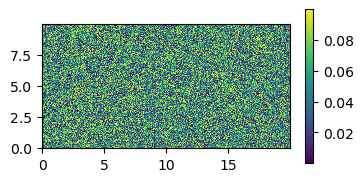

In [24]:
Lx = 20
Ly = 10
Nx = 512
Ny = int(Nx/2)
sigrand=0.1
xlin,ylin,xm,ym,uarr,dx,dy=setup_u(Lx,Ly,Nx,Ny,sigrand)
#r = 0.5
#print('dx,dy = ',dx,dy)
fig,ax = plt.subplots(1,1,figsize=(4,4))
ax.set_aspect(1)
im = ax.pcolormesh(xm,ym,uarr)  #show initial conditions
plt.colorbar(im,shrink=0.5)



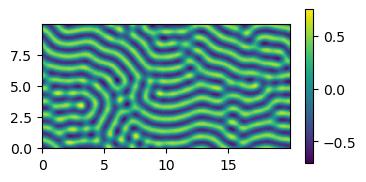

In [26]:
dt = 0.2; 
r=0.2
gammau=0.0
nsteps=400
unew  = uarr
fig,ax = plt.subplots(1,1,figsize=(4,4))
for i in range(1):
    #plt.figure()
    for j in range(nsteps):
        unew = do_1_step_SHp_2d(unew,dx,dy,dt,r,gammau)
    im=ax.pcolormesh(xm,ym,unew)
    plt.colorbar(im,shrink=0.5)
ax.set_aspect(1)

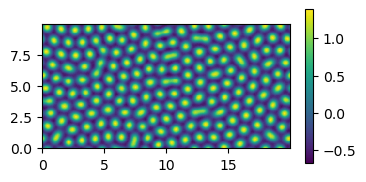

In [27]:
dt = 0.2; 
r=0.2
gammau=1.0
nsteps=400
unew  = uarr
fig,ax = plt.subplots(1,1,figsize=(4,4))
for i in range(1):
    #plt.figure()
    for j in range(nsteps):
        unew = do_1_step_SHp_2d(unew,dx,dy,dt,r,gammau)
    im=ax.pcolormesh(xm,ym,unew)
    plt.colorbar(im,shrink=0.5)
ax.set_aspect(1)